Copyright 2019 The TensorFlow Authors.
https://colab.research.google.com/github/tensorflow/tensorflow/blob/master/tensorflow/lite/g3doc/tutorials/model_maker_image_classification.ipynb#scrollTo=h2q27gKz1H20

In [ ]:
!pip install tflite-model-maker

In [2]:
import numpy as np
import tensorflow as tf
assert tf.__version__.startswith('2')

from tflite_model_maker import configs
from tflite_model_maker import ExportFormat
from tflite_model_maker import image_classifier
from tflite_model_maker import ImageClassifierDataLoader
from tflite_model_maker import model_spec

import matplotlib.pyplot as plt
print("Done importing!")

Done importing!


Mount Google Drive now.

In [ ]:
!unzip './drive/MyDrive/Colab_Notebooks/AndroidAge/age_data.zip'

In [4]:
image_path = './age_data'

Step 1. Load input data specific to an on-device ML app. Split it to training data and testing data.

In [5]:
data = ImageClassifierDataLoader.from_folder(image_path)
train_data, test_data = data.split(0.9)

INFO:tensorflow:Load image with size: 10674, num_label: 9, labels: 04-06, 07-08, 09-11, 12-19, 20-27, 28-35, 36-45, 46-60, 61-75.


Step 2. Customize/Train the TensorFlow model.

In [6]:
from datetime import datetime
x = datetime.now()
print(x)

epochs = 10  # 5 by default
batch_size = None # None by default
learning_rate = None # None by default
momentum = None # None by default
shuffle = False # False by default
use_augmentation = False # False by default

model = image_classifier.create(train_data, 
                                epochs=epochs, 
                                batch_size=batch_size)

y = datetime.now()
print(y)
print("Training duration: {}".format(abs(y-x)))

2020-11-23 10:40:37.827258
INFO:tensorflow:Retraining the models...
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hub_keras_layer_v1v2 (HubKer (None, 1280)              3413024   
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 9)                 11529     
Total params: 3,424,553
Trainable params: 11,529
Non-trainable params: 3,413,024
_________________________________________________________________
None
Epoch 1/10
300/300 [==============================] - 425s 1s/step - loss: 1.9291 - accuracy: 0.2929
Epoch 2/10
300/300 [==============================] - 399s 1s/step - loss: 1.6914 - accuracy: 0.3975
Epoch 3/10
300/300 [==============================] - 396s 1s/step - loss: 1.6577 - accuracy: 0.

Step 3. Evaluate the model.

In [7]:
loss, accuracy = model.evaluate(test_data)

34/34 [==============================] - 46s 1s/step - loss: 1.6116 - accuracy: 0.4373


We could plot the predicted results in 100 test images. Predicted labels with red color are the wrong predicted results while others are correct.

In [8]:
# A helper function that returns 'red'/'black' depending on if its two input
# parameter matches or not.
def get_label_color(val1, val2):
  if val1 == val2:
    return 'black'
  else:
    return 'red'

# Then plot 100 test images and their predicted labels.
# If a prediction result is different from the label provided label in "test"
# dataset, we will highlight it in red color.
plt.figure(figsize=(20, 20))
predicts = model.predict_top_k(test_data)
for i, (image, label) in enumerate(test_data.dataset.take(100)):
  ax = plt.subplot(10, 10, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(image.numpy(), cmap=plt.cm.gray)

  predict_label = predicts[i][0][0]
  color = get_label_color(predict_label,
                          test_data.index_to_label[label.numpy()])
  ax.xaxis.label.set_color(color)
  plt.xlabel('Predicted: %s' % predict_label)
plt.show()

Output hidden; open in https://colab.research.google.com to view.

Step 4. Export to (float?) TensorFlow Lite model.

In [ ]:
model.export(export_dir='.')
model.export(export_dir='.', export_format=ExportFormat.LABEL)
# model.export(export_dir='.', export_format=ExportFormat.TFLITE)

Save model to Google Drive

In [10]:
%cp 'model.tflite' './drive/MyDrive/Colab_Notebooks/AndroidAge/AndroidAge.tflite'
%cp 'labels.txt' './drive/MyDrive/Colab_Notebooks/AndroidAge/AndroidAge.txt'
print("Saved!")

Saved!


**After** this simple 4 steps, we could further use TensorFlow Lite model file in on-device applications like in [image classification](https://github.com/tensorflow/examples/tree/master/lite/examples/image_classification) reference app.

## Post-training quantization on the TensorFLow Lite model

[Post-training quantization](https://www.tensorflow.org/lite/performance/post_training_quantization) is a conversion technique that can reduce model size and inference latency, while also improving CPU and hardware accelerator latency, with little degradation in model accuracy. Thus, it's widely used to optimize the model.

Model Maker supports multiple post-training quantization options. Let's take full integer quantization as an instance. First, define the quantization config to enforce full integer quantization for all ops including the input and output. The input type and output type are `uint8` by default. You may also change them to other types like `int8` by setting `inference_input_type` and `inference_output_type` in config.

In [11]:
config = configs.QuantizationConfig.create_full_integer_quantization(representative_data=test_data, is_integer_only=True)

Then we export the **quantized** TensorFlow Lite model with such configuration.

In [12]:
model.export(export_dir='.', tflite_filename='model_quant.tflite', quantization_config=config)

INFO:tensorflow:Assets written to: /tmp/tmp_vw43kwe/assets


INFO:tensorflow:Assets written to: /tmp/tmp_vw43kwe/assets


INFO:tensorflow:Label file is inside the TFLite model with metadata.


INFO:tensorflow:Label file is inside the TFLite model with metadata.


INFO:tensorflow:Saving labels in /tmp/tmp4k0xz9xd/labels.txt.


INFO:tensorflow:Saving labels in /tmp/tmp4k0xz9xd/labels.txt.


In [13]:
%cp 'model_quant.tflite' './drive/MyDrive/Colab_Notebooks/AndroidAge/AndroidAge_quant.tflite'

## Optional: Show Loss and Accuracy graph

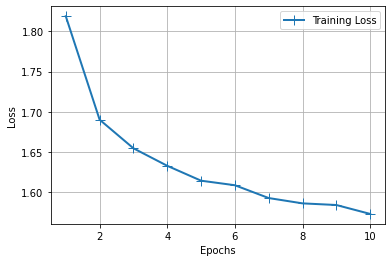

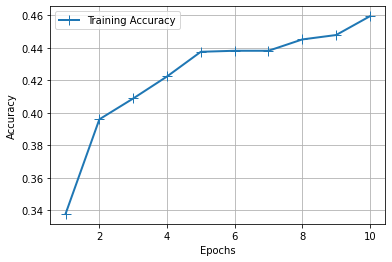

In [33]:
import matplotlib.pyplot as plt
%matplotlib inline

history_dict = model.history.history

### LOSS:
loss_values = history_dict['loss']
epochs = range(1, len(loss_values) + 1)
line1 = plt.plot(epochs, loss_values, label='Training Loss')
plt.setp(line1, linewidth=2.0, marker = '+', markersize=10.0)
plt.xlabel('Epochs') 
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

### ACCURACY:
acc_values = history_dict['accuracy']
epochs = range(1, len(loss_values) + 1)
line1 = plt.plot(epochs, acc_values, label='Training Accuracy')
plt.setp(line1, linewidth=2.0, marker = '+', markersize=10.0)
plt.xlabel('Epochs') 
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()

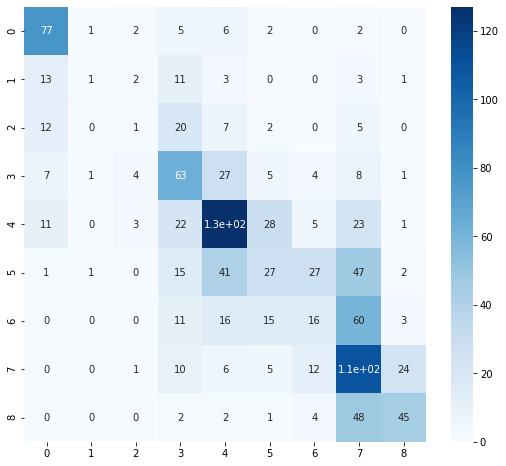

In [69]:
from sklearn.metrics import confusion_matrix
from keras.models import load_model
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
%matplotlib inline 

lookUp = {
    "04-06": 0,
    "07-08": 1,
    "09-11": 2,
    "12-19": 3,
    "20-27": 4,
    "28-35": 5,
    "36-45": 6,
    "46-60": 7,
    "61-75": 8
}
predicts = model.predict_top_k(test_data)
predict_labels = [lookUp[predicts[i][0][0]] for i, (image, label) in enumerate(test_data.dataset)]
real_labels = [label.numpy() for i, (image, label) in enumerate(test_data.dataset)]

plt.figure(figsize=(9,8))
cm = confusion_matrix(y_true = real_labels,
                      y_pred = predict_labels)
sn.heatmap(cm, annot=True, cmap="Blues")

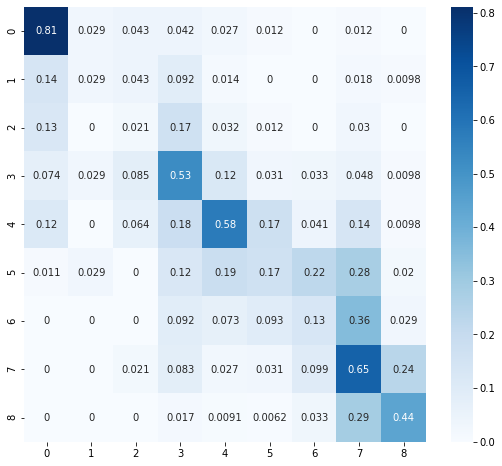

In [70]:
# Show confusion matrix as percentage
cm = cm / cm.sum(axis=1) # Show in procents %
plt.figure(figsize=(9,8))
sn.heatmap(cm, annot=True, cmap="Blues")